In [3]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!unzip -uq "/content/drive/My Drive/datasets/pose.zip" -d "/content/drive/My Drive/datasets"

In [6]:
images, labels = pkl.load(open('/content/drive/My Drive/datasets/pose/samples.pkl', 'rb'))

print(images.shape, labels.shape)

(6288, 2278) (6288, 3)


In [7]:
labels[0]

array([ 0.5956949 ,  3.03410077, -4.09082985])

In [8]:
len(images[0])

2278

In [9]:
roll, pitch, yaw = labels[:, 0], labels[:, 1], labels[:, 2]

In [10]:
print(roll.min(), roll.max(), roll.mean(), roll.std())
print(pitch.min(), pitch.max(), pitch.mean(), pitch.std())
print(yaw.min(), yaw.max(), yaw.mean(), yaw.std())

-46.06486893 43.00866699 -0.52579503197042 5.176231116713095
-29.88856888 34.09674835 2.584682740273537 7.962828151857226
-75.55059814 86.84925079 -0.11620588007315523 13.090839183150852


In [11]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [12]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(4401, 2278) (4401, 3)
(943, 2278) (943, 3)
(944, 2278) (944, 3)


In [13]:
std = StandardScaler()
std.fit(x_train)
x_train = std.transform(x_train)
x_val = std.transform(x_val)
x_test = std.transform(x_test)

## Model hyperparameters

In [14]:
# set batch size and epoch
EPOCHS = 200
BATCH_SIZE = 16

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=20, activation='relu', kernel_regularizer='l2', input_dim=images.shape[1]))
model.add(tf.keras.layers.Dense(units=10, activation='relu', kernel_regularizer='l2'))
model.add(tf.keras.layers.Dense(units=3, activation='linear'))

callback_list = [EarlyStopping(monitor='val_loss', patience=25)]

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'] )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                45580     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 45,823
Trainable params: 45,823
Non-trainable params: 0
_________________________________________________________________


In [16]:
hist = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callback_list)

Epoch 1/200
276/276 [==============================] - 1s 3ms/step - loss: 50.8885 - accuracy: 0.6226 - val_loss: 48.5173 - val_accuracy: 0.6151
Epoch 2/200
276/276 [==============================] - 1s 3ms/step - loss: 43.1956 - accuracy: 0.6583 - val_loss: 44.8091 - val_accuracy: 0.6797
Epoch 3/200
276/276 [==============================] - 1s 3ms/step - loss: 38.7306 - accuracy: 0.6696 - val_loss: 41.6064 - val_accuracy: 0.6861
Epoch 4/200
276/276 [==============================] - 1s 3ms/step - loss: 36.6038 - accuracy: 0.6892 - val_loss: 35.3207 - val_accuracy: 0.7275
Epoch 5/200
276/276 [==============================] - 1s 3ms/step - loss: 36.3004 - accuracy: 0.7007 - val_loss: 38.7269 - val_accuracy: 0.6776
Epoch 6/200
276/276 [==============================] - 1s 3ms/step - loss: 35.5331 - accuracy: 0.7137 - val_loss: 37.0746 - val_accuracy: 0.7211
Epoch 7/200
276/276 [==============================] - 1s 3ms/step - loss: 35.5098 - accuracy: 0.7135 - val_loss: 36.1275 - val_ac

In [17]:
model.save('/content/drive/My Drive/models/head_pose_model.h5')

In [18]:
Train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: ', Train_score[0])
print('Train accuracy: ', Train_score[1])

Val_score = model.evaluate(x_val, y_val, verbose=0)
print('Val loss: ', Val_score[0])
print('Val accuracy: ', Val_score[1])

Test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: ', Test_score[0])
print('Test accuracy: ', Test_score[1])

Train loss:  32.14155578613281
Train accuracy:  0.7446035146713257
Val loss:  34.67989730834961
Val accuracy:  0.738070011138916
Test loss:  41.864383697509766
Test accuracy:  0.7319915294647217


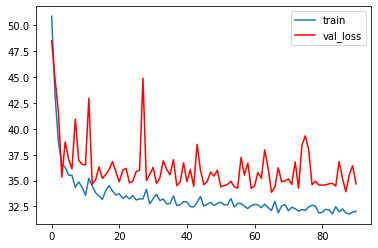

In [19]:
history = hist.history
loss_train = history['loss']
loss_val = history['val_loss']

plt.figure()
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='val_loss', color='red')
plt.legend()
plt.savefig('/content/drive/My Drive/reports/train_val_head_pose.png')

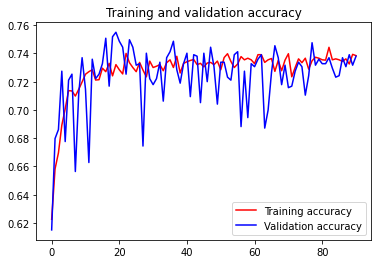

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [20]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
#prec = histories.history['precision']
#val_prec = histories.history['val_precision']
#recall = histories.history['recall']
#val_recall = histories.history['val_recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()
plt.savefig("/content/drive/My Drive/head_train_val_acc_200_epochs_batch_64.png")

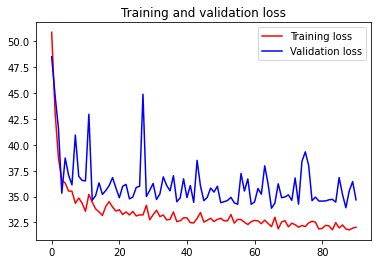

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [21]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()
plt.savefig("/content/drive/My Drive/reports/head_train_val_loss_100_epochs_batch_64.png")

In [22]:
hist.history

{'accuracy': [0.6225857734680176,
  0.6582595109939575,
  0.6696205139160156,
  0.6891615390777588,
  0.7007498145103455,
  0.7137014269828796,
  0.7134742140769958,
  0.7098386883735657,
  0.7146103382110596,
  0.719836413860321,
  0.7252897024154663,
  0.7271074652671814,
  0.7284708023071289,
  0.7211997509002686,
  0.7214269638061523,
  0.7296069264411926,
  0.7271074652671814,
  0.733015239238739,
  0.7241535782814026,
  0.7321063280105591,
  0.7284708023071289,
  0.7255169153213501,
  0.7400590777397156,
  0.7334696650505066,
  0.7300613522529602,
  0.7271074652671814,
  0.7336968779563904,
  0.7282435894012451,
  0.7234719395637512,
  0.7346057891845703,
  0.7300613522529602,
  0.7309702634811401,
  0.7321063280105591,
  0.7277891635894775,
  0.7334696650505066,
  0.7355146408081055,
  0.7300613522529602,
  0.7380141019821167,
  0.7261986136436462,
  0.733015239238739,
  0.734151303768158,
  0.7350602149963379,
  0.7357418537139893,
  0.7321063280105591,
  0.733015239238739,
  0

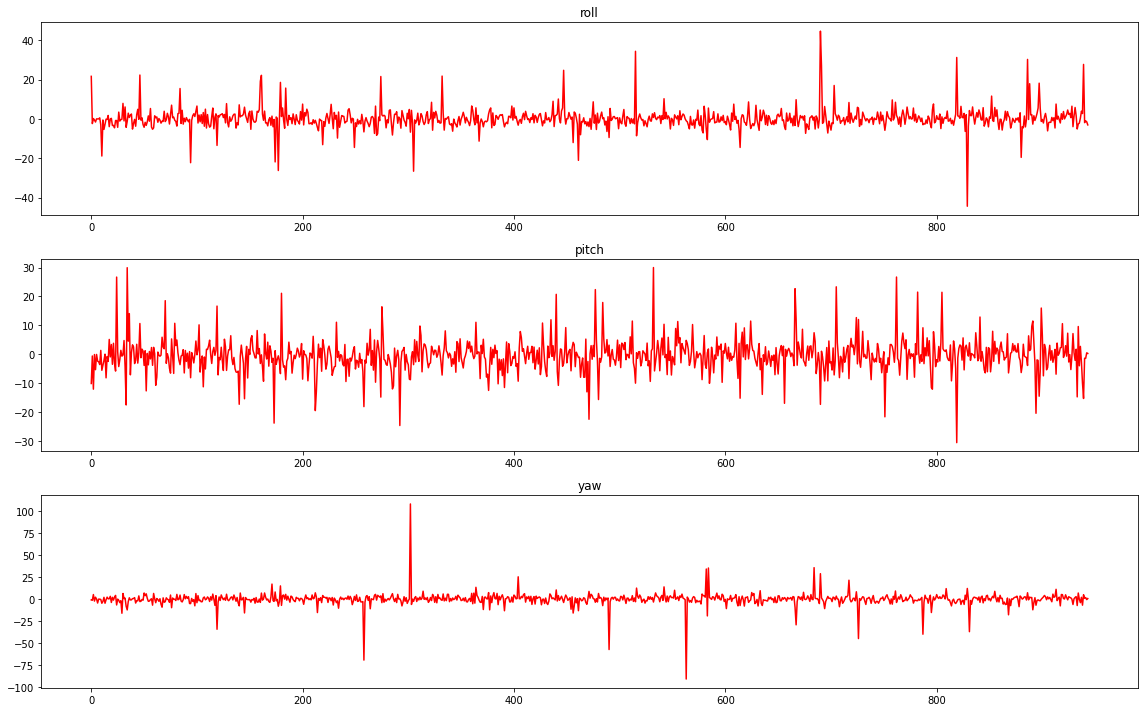

In [23]:
y_pred = model.predict(x_test)
diff = y_test - y_pred
diff_roll = diff[:, 0]
diff_pitch = diff[:, 1]
diff_yaw = diff[:, 2]

plt.figure(figsize=(16, 10))

plt.subplot(3, 1, 1)
plt.plot(diff_roll, color='red')
plt.title('roll')

plt.subplot(3, 1, 2)
plt.plot(diff_pitch, color='red')
plt.title('pitch')

plt.subplot(3, 1, 3)
plt.plot(diff_yaw, color='red')
plt.title('yaw')

plt.tight_layout()
plt.savefig("/content/drive/My Drive/reports/roll_picth_yaw_pred.png")

## Testing Model

In [24]:
def detect_face_points(image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("/content/drive/My Drive/shape_predictor_68_face_landmarks.dat")
    face_rect = detector(image, 1)
    if len(face_rect) != 1: return []
    
    dlib_points = predictor(image, face_rect[0])
    face_points = []
    for i in range(68):
        x, y = dlib_points.part(i).x, dlib_points.part(i).y
        face_points.append(np.array([x, y]))
    return face_points
        
def compute_features(face_points):
    assert (len(face_points) == 68), "len(face_points) must be 68"
    
    face_points = np.array(face_points)
    features = []
    for i in range(68):
        for j in range(i+1, 68):
            features.append(np.linalg.norm(face_points[i]-face_points[j]))
            
    return np.array(features).reshape(1, -1)

 Roll: 0.66°
Pitch: -2.58°
  Yaw: 23.60°


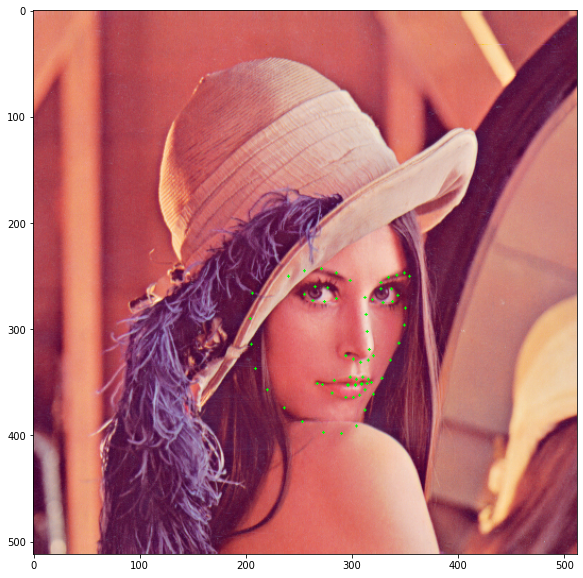

In [25]:
im = cv2.imread('/content/drive/My Drive/datasets/lena_std.tif', cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
face_points = detect_face_points(im)

for x, y in face_points:
    cv2.circle(im, (x, y), 1, (0, 255, 0), -1)
    
features = compute_features(face_points)
features = std.transform(features)

model = tf.keras.models.load_model('/content/drive/My Drive/models/head_pose_model.h5')
y_pred = model.predict(features)

roll_pred, pitch_pred, yaw_pred = y_pred[0]
print(' Roll: {:.2f}°'.format(roll_pred))
print('Pitch: {:.2f}°'.format(pitch_pred))
print('  Yaw: {:.2f}°'.format(yaw_pred))
    
plt.figure(figsize=(10, 10))
plt.imshow(im)